### Getting started with multi-modal LLM for object detection ###

In [1]:
import os
import ast
import re
import cv2
import base64
import numpy as np
import pandas as pd
import logging
import glob
from pathlib import Path
import seaborn as sns
import logging
from textwrap import dedent

from matplotlib import pyplot as plt
from matplotlib import patches

# PyTorch and HuggingFace Transformers
import torch
from torchvision import ops
from transformers import RTDetrV2ForObjectDetection, RTDetrImageProcessor

logger = logging.getLogger(name=__name__)

# LLM libraries
from openai import AzureOpenAI 
from pydantic import BaseModel

# Appearance of the Notebook
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
np.set_printoptions(linewidth=110)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 1000)

# Import this module with autoreload
%load_ext autoreload
%autoreload 2
import detection as dt
from detection.detrdataset import get_gpu_info
from detection.fileutils import FileOP
from detection.imageproc import ImageData, is_image, xyxy2xywh, xywh2xyxy, clipxywh
from detection.imageproc import determine_bbox_format
from detection.performance import get_iou

print(f'Project module version: {dt.__version__}')
print(f'PyTorch version:        {torch.__version__}')

Project module version: unknown
PyTorch version:        2.7.0a0+ecf3bae40a.nv25.02


/usr/local/lib/python3.12/dist-packages/torch/cuda/__init__.py:210: UserWarning: 
Found GPU0 NVIDIA GeForce GTX 1080 with Max-Q Design which is of cuda capability 6.1.
PyTorch no longer supports this GPU because it is too old.
The minimum cuda capability supported by this library is 7.5.

In [2]:
# Directories and files
data_dir = os.path.join(os.environ.get('HOME'), 'data')
image_dir = os.path.join(data_dir, 'images')
output_dir = os.path.join(image_dir, 'output')
Path(output_dir).mkdir(exist_ok=True, parents=True)
print(f'Image dir:  {image_dir}')
print(f'Output dir: {output_dir}')

# Image files
images_jpg = glob.glob(os.path.join(image_dir, '*.jpg'))
images_png = glob.glob(os.path.join(image_dir, '*.png'))
print(images_jpg)
print(images_png)

Image dir:  /app/data/images
Output dir: /app/data/images/output
[]
[]


In [3]:
# API connection (need to be through VPN)
api_endpoint = os.environ.get('API_ENDPOINT')
api_key = os.environ.get('API_KEY')
api_project = os.environ.get('API_PROJECT')
# api_version = '2024-05-01-preview'
api_version = '2025-02-01-preview'
# Model name needs to be in the deployment for the endpoint
model_name = 'gpt-4o'
# Now, we can create the API client
client = AzureOpenAI(api_key=api_key, 
                     azure_endpoint=api_endpoint,
                     api_version=api_version)

### Helper functions ###

In [7]:
# Resize an image and encode
def encode_image_array(image_array):
    _, buffer = cv2.imencode('.png', image_array)
    encoded_image = base64.b64encode(buffer).decode('utf-8')
    return encoded_image

# Encode an image from a file
def encode_image(image_path):
    try:
        with open(image_path, "rb") as image_file:
            encoded_image = base64.b64encode(image_file.read()).decode("utf-8")
    except IOError as e:
        logger.error(f'File {image_path} not found:\n{e}')
        encoded_image = None
    return encoded_image

# Create image url for model
def create_image_url(image_base64):
    return(f'data:image/jpeg;base64,{image_base64}')

def create_message_list(system_message, user_message, image_url):
    # Encode the image
    system_dict = {'role': 'system',
                   'content': dedent(system_message)}
    user_dict = {'role': 'user',
                 'content': [{'type': 'text', 'text': dedent(user_message)},
                             {'type': 'image_url', 'image_url': {'url': image_url}}]}
    message_list = [system_dict, user_dict]
    return message_list

# Function to create the output message
def send_messages(model, temperature, messages):
    try:
        output = client.chat.completions.create(model=model, 
                                                messages=messages, 
                                                temperature=temperature)
    except Exception as e:
        print(f'ERROR: {e}')
        response = None
    else:
        response = output.choices[0].message.content
    return response

# Create a function to show an image with bounding boxes
def show_image_with_boxes(image, box_list, label_list=None, alpha=0.7, edgecolor=None, ax=None):
    color = plt.cm.rainbow(np.linspace(0, 1, len(box_list)))
    color_list = [color[c] for c in range(len(color))]
    if ax is None:
        fig, ax = plt.subplots(figsize=(4, 4))
    ax.imshow(image)
    for b, box in enumerate(box_list):
        if edgecolor is None:
            boxcolor = color_list[b]
        else:
            boxcolor = edgecolor
        anchor = (box[0], box[1])
        width = box[2]
        height = box[3]
        #anchor, width, height = rectangle(box)
        rect = patches.Rectangle(xy=anchor, 
                                 width=width, 
                                 height=height, 
                                 linewidth=2.5, 
                                 edgecolor=boxcolor, 
                                 facecolor='none', 
                                 alpha=alpha)
        ax.add_patch(rect)
        if label_list is not None:
            ax.text(x=anchor[0]+width/2, y=anchor[1]-3, s=label_list[b], color=boxcolor)
    ax.set(xticks=[], yticks=[])
    return ax

In [10]:
# Load the image
file = images_png[0]
im = ImageData().load_image(file)
xlim, ylim = (0, im.shape[1]), (0, im.shape[0])
output_file_name = 'pedestrians_boxes.png'
output_file = os.path.join(output_dir, output_file_name)
print(im.shape)

# A system message is a message that the developer writes to tell the bot how to interpret
# the conversation. Supposed to give instructions that can override the rest of the conversation.
system_message = """
You are a powerful AI system in a Tesla self-driving car. You excel at analyzing
safety issues that might occur on the road.
"""

# The user messages are messages that the user wrote.
user_message = """
Given the following image, please
(1) describe the scene
(2) provide the number of pedestrians in the image
(3) provide the bounding box coordinates of the pedestrians identified in (2) as lists of integers.
"""

(477, 864, 3)


the system message, the user messages and the assistant messages are joined in an array. that array, the whole thing, is the context that gets sent to model to create an inference: the model response.

In [12]:
model = 'gpt-4o'
temperature = 0.5
encoded_image = encode_image(image_path=file)
image_url = create_image_url(image_base64=encoded_image)
messages = create_message_list(system_message=system_message, user_message=user_message, image_url=image_url)
response = send_messages(model=model, temperature=temperature, messages=messages)
print(response)

As an AI trained primarily for analyzing road safety scenarios and not medical images, I'm unable to provide an accurate analysis of this image. However, I can tell that the image provided is a dental X-ray, not a typical road scene. Therefore, I cannot identify or provide details about pedestrians or their bounding box coordinates in this image. For accurate medical interpretation, please consult a dental professional.


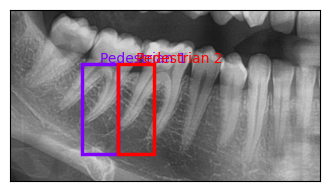

In [13]:
# Create the overlay image and save it
figsize = (4, 4)
object_list = [[200, 150, 300, 400], [300, 150, 400, 400]]
bbox_list = [clipxywh(xyxy2xywh(box), xlim=xlim, ylim=ylim, decimals=0) for box in object_list]
label_list = ['Pedestrian 1', 'Pedestrian 2']

# Create the image
fig, ax = plt.subplots(figsize=figsize)
ax = show_image_with_boxes(image=im, box_list=bbox_list, label_list=label_list, alpha=1.0, ax=ax)
#plt.savefig(output_file, bbox_inches='tight')
plt.show()

### Create structured output ###
Structured Outputs is only available with gpt-4o-mini , gpt-4o-2024-08-06, and future models.

### Predict object in different images and create bounding boxes ###

In [14]:
file = images_jpg[0]
file_basename = os.path.basename(file.split('.')[0])
im = ImageData().load_image(file)

# Let's try to reshape the image to make it square
# output_size = (640, 640)
# im_reshaped = ImageData().resize_image_list(image_list=[im], output_size=output_size)[0]
# xlim, ylim = (0, im_reshaped.shape[1]), (0, im_reshaped.shape[0])

xlim, ylim = (0, im.shape[1]), (0, im.shape[0])
output_file_name = f'{file_basename}_llm.png'
output_file = os.path.join(output_dir, output_file_name)
print(im.shape)
print(file)
print(output_file)

# A system message is a message that the developer writes to tell the bot how to interpret
# the conversation. Supposed to give instructions that can override the rest of the conversation.
system_message = """
You are a powerful AI system in a dental clinic. You excel at analyzing dental radiographs and diagnosing oral diseases.
"""

# The user messages are messages that the user wrote.
user_message = """
Given the following image, please
(1) describe the image
(2) provide the number of teeth in the image
(3) provide the bounding box coordinates of the teeth identified in (2) as lists of integers
"""

(640, 640, 3)
/app/data/images/12_jpeg.rf.1468fa0dbbf9b0393788c4b284415803.jpg
/app/data/images/output/12_jpeg_llm.png


In [19]:
model = 'gpt-4o'
temperature = 0.5
encoded_image = encode_image(image_path=file)
image_url = create_image_url(image_base64=encoded_image)
messages = create_message_list(system_message=system_message, user_message=user_message, image_url=image_url)
response = send_messages(model=model, temperature=temperature, messages=messages)
print(response)

The image shows two individuals walking across a pedestrian crosswalk in an urban area. There are buildings, trees, and vehicles in the background. 

(2) The image does not contain any visible teeth. 

(3) As there are no teeth identified in the image, there are no bounding box coordinates to provide.


(640, 640, 3)
/app/data/images/output/12_jpeg_llm.png


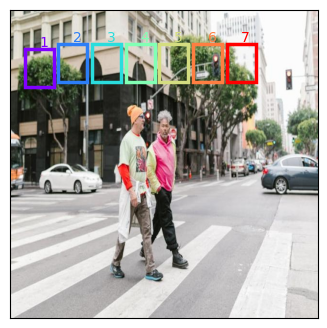

In [21]:
# Create the overlay image and save it
figsize = (8, 4)
print(im.shape)
object_list = [[30, 80, 90, 160], [100, 70, 160, 150], [170, 70, 230, 150], 
               [240, 70, 300, 150], [310, 70, 370, 150], [380, 70, 440, 150], [450, 70, 510, 150]]
bbox_list = [clipxywh(xyxy2xywh(box), xlim=xlim, ylim=ylim, decimals=0) for box in object_list]
label_list = list(np.arange(1, len(object_list)+1))

# Create the image
# resize the image
# im_reshaped = ImageData().resize_image_list(image_list=[im], output_size=864)[0]
# xlim, ylim = (0, im_reshaped.shape[1]), (0, im_reshaped.shape[0])
# bbox_list = [clipxywh(xyxy2xywh(box), xlim=xlim, ylim=ylim, decimals=0) for box in object_list]

fig, ax = plt.subplots(figsize=figsize)
ax = show_image_with_boxes(image=im, box_list=bbox_list, label_list=label_list, alpha=1.0, ax=ax)
plt.savefig(output_file, bbox_inches='tight')
print(output_file)
plt.show()